In [1]:
# essentials
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os, sys
from scipy.stats import gamma, beta

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.computational_utilities import simultaneous_ecdf_bands

In [2]:
sys.path.append("../src")
from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks import DynamicGaussianNetworkJoint
from context import generate_design_matrix
from transformations import unscale_z, scale_z

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-23 13:00:29.329459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 13:00:29.358477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 13:00:29.358629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
N_OBS         = 3200
T             = 3200
N_PARAMS      = 6
N_SBC         = 2000
N_SAMPLES_SBC = 200

DIST_MAT = build_distance_matrix(N_OBS)
AMPLITUDES = [0.1, 0.1, 0.1, 0.1, 0.05, 0.05]

TIME_SLICES = np.array([800, 1600, 2400, 3200]) - 1

2022-11-23 13:00:29.390883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 13:00:29.391419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 13:00:29.391598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 13:00:29.391724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
MACRO_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
MACRO_STD = [2.8, 2.8, 2.8, 2.8, 2.8, 2.8]

MICRO_MEAN = [1.3, 1.3, 1.3, 1.3, 1.3, 0.3]
MICRO_STD = [1.0, 1.0, 1.0, 1.0, 0.75, 0.25]

In [6]:
# def generator_fun(batch_size):
#     theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
#     eta = length_scale_prior(batch_size, N_PARAMS)
#     theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
#     context = generate_design_matrix(batch_size, N_OBS)

#     rt = dynamic_batch_diffusion(theta_t, context)
#     x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

#     eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
#     theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

#     return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x.astype(np.float32)

In [7]:
def generator_fun(batch_size):
    repeat = True
    while repeat:
        theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
        eta = length_scale_prior(batch_size, N_PARAMS)
        theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
        if min(theta_t[:, :, 4].flatten()) > 0.059:
            repeat = False
            
    context = generate_design_matrix(batch_size, T)

    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x.astype(np.float32)

In [8]:
# network_settings = {
#     'embedding_gru_units': 256,
#     'embedding_lstm_units' : 256,
#     'dense_pre_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
#     'dense_micro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
#     'dense_macro_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
#     'macro_lstm_units': 128,
#     'n_micro_params': 6,
#     'n_macro_params': 6
# }
# network = DynamicGaussianNetwork(network_settings)

network_settings = {
    'embedding_lstm_units' : 512, 
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [9]:
# network.load_weights('../trained_networks/gp_ddm_3200_joint_offline_factorized_new')
network.load_weights('../trained_networks/gpddm_3200_joint_offline_cosineDecay_newData8000_2')

## SBC

In [10]:
def presimulate_data():
    for n in range(N_SBC):
        eta_z, theta_t_z, x = generator_fun(1)
        np.save(f'../data/sbc_data/data/x_{n}.npy', x)
        np.save(f'../data/sbc_data/parameters/eta/eta_eta_params_{n}.npy', eta_z)
        np.save(f'../data/sbc_data/parameters/theta/theta_theta_params_{n}.npy', theta_t_z)

In [11]:
# presimulate_data()

In [12]:
eta_z = np.zeros((N_SBC, N_PARAMS))
theta_t_z = np.zeros((N_SBC, N_OBS, N_PARAMS))
data = np.zeros((N_SBC, N_OBS, 5))
for n in range(N_SBC):
    eta_z[n] = np.load(f'../data/sbc_data/parameters/eta/eta_eta_params_{n}.npy')
    theta_t_z[n] = np.load(f'../data/sbc_data/parameters/theta/theta_theta_params_{n}.npy')
    data[n] = np.load(f'../data/sbc_data/data/x_{n}.npy')

In [13]:
true_theta = unscale_z(theta_t_z, MICRO_MEAN, MICRO_STD)
true_eta = unscale_z(eta_z, MACRO_MEAN, MACRO_STD)

In [14]:
n_chunks = 200
chunk_len = int(data.shape[0] / n_chunks)
chunk_len

10

In [15]:
%%time
counter = 0
theta_z_pred = np.zeros((N_SAMPLES_SBC, N_SBC, len(TIME_SLICES), N_PARAMS))
eta_z_pred = np.zeros((N_SAMPLES_SBC, N_SBC, N_PARAMS))
for x in tf.split(data, n_chunks, axis=0):
    dists = network(x)
    post = dists.sample(N_SAMPLES_SBC).numpy()
    theta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[:, :, TIME_SLICES, 6:]
    eta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[:, :, -1, :6]
    print(counter)
    counter += 1

2022-11-23 13:00:40.673823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
CPU times: user 41 s, sys: 22.2 s, total: 1min 3s
Wall time: 1min 3s


In [16]:
theta_pred = unscale_z(theta_z_pred, MICRO_MEAN, MICRO_STD)
eta_pred = unscale_z(eta_z_pred, MACRO_MEAN, MACRO_STD)

In [17]:
theta_pred_sbc = np.transpose(theta_pred, (1, 0, 2, 3))

theta_pred_means = np.mean(theta_pred, axis=0)
theta_pred_stds = np.std(theta_pred, axis=0)
eta_pred_mean = np.mean(eta_pred, axis=0)
eta_pred_std = np.std(eta_pred, axis=0)

In [18]:
np.save("../saved_arrays/sbc_theta_pred.npy", theta_pred_sbc)
np.save("../saved_arrays/sbc_true_theta.npy", true_theta)

In [20]:
theta_pred_sbc = np.load("../saved_arrays/sbc_theta_pred.npy")
true_theta = np.load("../saved_arrays/sbc_true_theta.npy")

In [21]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

FONT_SIZE_1 = 20
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18
FONT_SIZE_4 = 16

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [22]:
def plot_sbc_ecdf(post, prior, fill_color='grey', difference=True, **kwargs):

    fig = plt.figure(figsize=(19, 16), constrained_layout=True)

    # create 4x1 subfigs
    subfigs = fig.subfigures(nrows=len(TIME_SLICES), ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'$t = {(TIME_SLICES+1)[row]}$', fontsize=FONT_SIZE_1, fontweight='bold')

        post_samples = post[:, :, row, :]
        prior_samples = prior[:, TIME_SLICES[row], :]

        # Store reference to number of parameters
        n_params = post_samples.shape[-1]
        
        # Compute fractional ranks (using broadcasting)    
        ranks = np.sum(post_samples < prior_samples[:, np.newaxis, :], axis=1) / post_samples.shape[1]

        # Compute uniform ECDF and bands
        alpha, z, L, H = simultaneous_ecdf_bands(post_samples.shape[0], **kwargs.pop('ecdf_bands_kwargs', {}))

        if difference:
            L -= z
            H -= z

        # create 1x6 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=6)
        for col, ax in enumerate(axs):
            ecdf_single = np.sort(ranks[:, col])
            xx = ecdf_single
            yy = np.arange(1, xx.shape[-1]+1)/float(xx.shape[-1])
            
            if difference:
                yy -= xx
            
            if col == 0:
                ax.plot(xx, yy, color='#852626', alpha=0.8, label='Rank ECDF', lw=1)
                ax.fill_between(z, L, H, color=fill_color, linewidth=0, alpha=0.3, label=f'{int((1-alpha) * 100)}% Confidence Bands')
            else:
                ax.plot(xx, yy, color='#852626', alpha=0.8, lw=1)
                ax.fill_between(z, L, H, color=fill_color, linewidth=0, alpha=0.3)

            # ax.grid(alpha=0.2)
            ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
            sns.despine(ax=ax)

            if row == 0:
                ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel('Fractional rank statistic', fontsize=FONT_SIZE_3)
                    if difference:
                        ylab = 'ECDF difference'
                    else:
                        ylab = 'ECDF'
                    ax.set_ylabel(ylab, fontsize=FONT_SIZE_3)
            else:
                ax.set_title(' ', fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel(' ', fontsize=FONT_SIZE_3)
                    ax.set_ylabel(' ', fontsize=FONT_SIZE_3)


    subfigs[3].legend(fontsize=FONT_SIZE_3, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=2)

    plt.savefig("../plots/sbc_gpddm.pdf", dpi=300, bbox_inches="tight")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Palatino
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Palatino
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Palatino
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Palatino


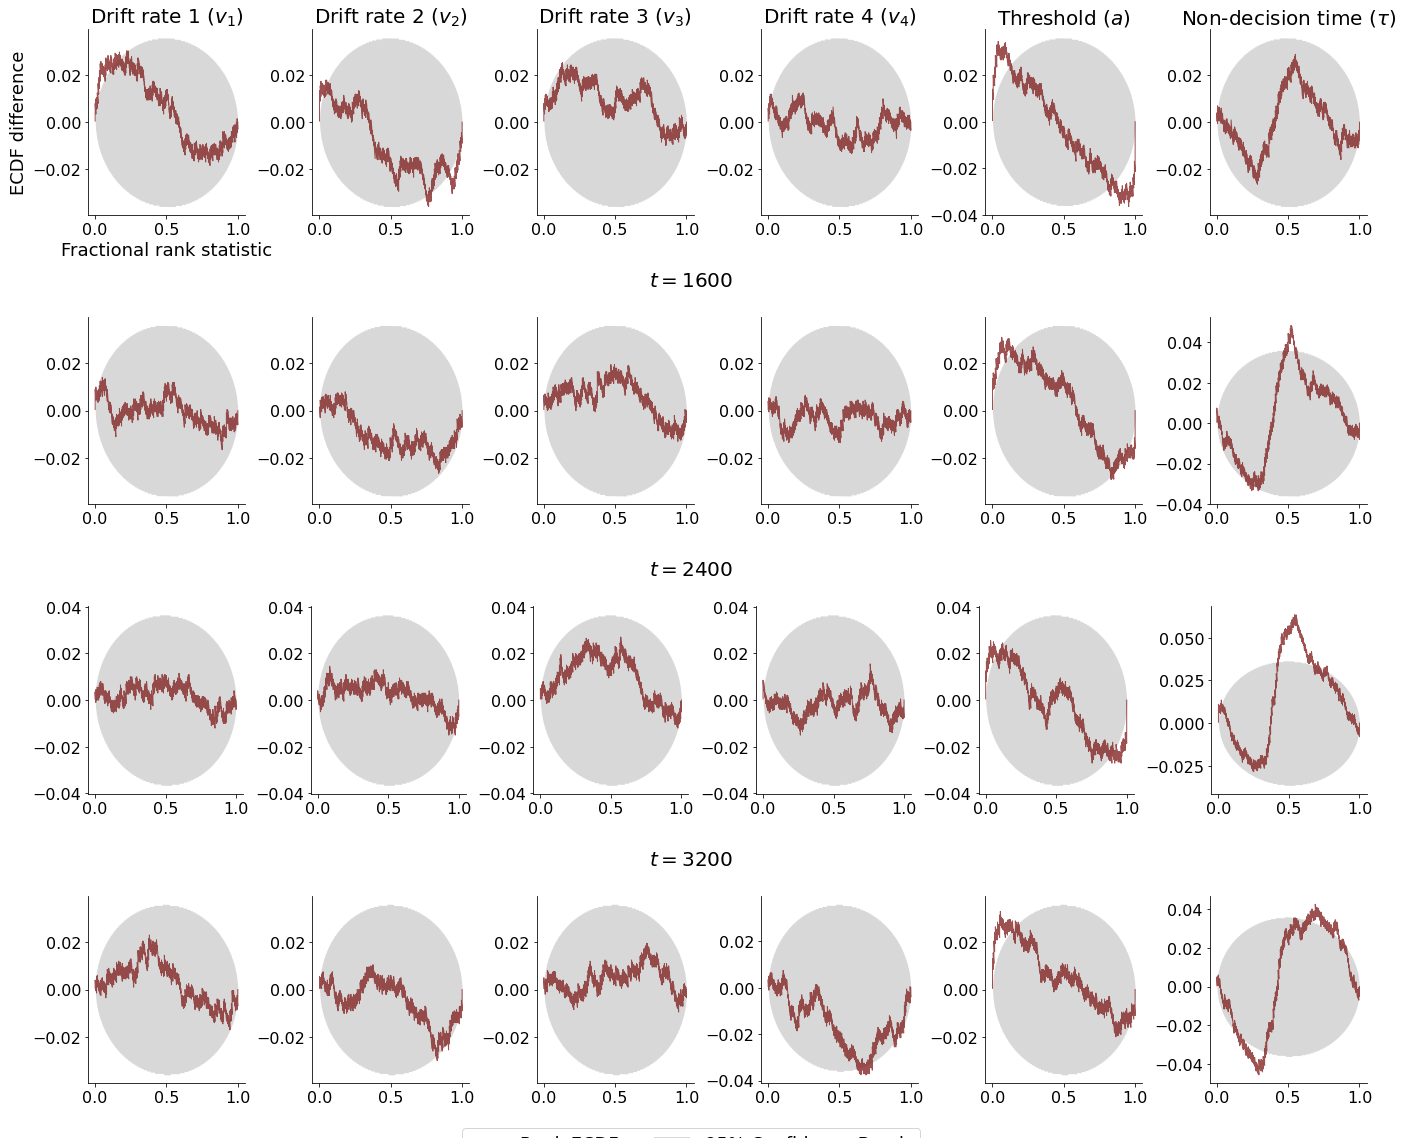

In [23]:
plot_sbc_ecdf(theta_pred_sbc, true_theta)